In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
import unicodedata
import tensorflow_datasets as tfds
import time
plt.style.use('seaborn')

In [0]:
tf.__version__

'2.2.0-rc1'

In [0]:
data, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQEWRBY/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQEWRBY/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQEWRBY/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [0]:
data

{'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>,
 'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>,
 'validation': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>}

In [0]:
metadata

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)

In [0]:
train_data = data['train']
val_data = data['validation']

In [0]:
for n, i in enumerate(train_data):
  print(i[0])
  print()
  print(i[1])
  if n == 0:
    break

tf.Tensor(b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .', shape=(), dtype=string)

tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)


## TFDS tokenizer

In [0]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_data), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt, en in train_data), target_vocab_size=2**13)

In [0]:
sample_string = 'This is Transfomer Network Practice'

tokenized_string = tokenizer_en.encode(sample_string)

revert_string = tokenizer_en.decode(tokenized_string)

print('Original Sentence : ', sample_string)
print('Tokenized Sentence: ', tokenized_string)
print('Reverted Sentence : ', revert_string)

Original Sentence :  This is Transfomer Network Practice
Tokenized Sentence:  [7915, 128, 13, 7915, 1248, 7946, 1391, 2762, 7863, 7909, 1283, 187, 7911, 3439, 1510, 7932]
Reverted Sentence :  This is Transfomer Network Practice


In [0]:
for ts in tokenized_string:
  print(f'{ts} --- {tokenizer_en.decode([ts])}')

7915 --- T
128 --- his 
13 --- is 
7915 --- T
1248 --- ran
7946 --- s
1391 --- fo
2762 --- mer
7863 ---  
7909 --- N
1283 --- et
187 --- work 
7911 --- P
3439 --- rac
1510 --- tic
7932 --- e


In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [0]:
# Size of the vocabulary. Decode produces ints [1, vocab_size).
tokenizer_pt.vocab_size

8214

In [0]:
tokenizer_pt.save_to_file('pt_tokenizer')

In [0]:
len(tokenizer_pt.subwords)

7957

In [0]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size+1]
  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size+1]

  return lang1, lang2

In [0]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])
  return result_pt, result_en

In [0]:
MAX_LENGTH = 40

In [0]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [0]:
train_preprocess = train_data.map(tf_encode).filter(filter_max_length).cache().shuffle(BUFFER_SIZE)

val_preprocess = val_data.map(tf_encode).filter(filter_max_length)

In [0]:
train_preprocess

<DatasetV1Adapter shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

In [0]:
for n, i in enumerate(train_preprocess):
  print(i)
  print(i[0])
  print()
  print(i[1])
  if n == 0:
    break

(<tf.Tensor: shape=(13,), dtype=int64, numpy=
array([8214,   42, 1239,    3, 1026, 2908, 2401,  933,   11,  174,  225,
          2, 8215])>, <tf.Tensor: shape=(13,), dtype=int64, numpy=
array([8087,   16,  344,  737, 1743, 1666, 5335,  180,   21,  138,  181,
          2, 8088])>)
tf.Tensor([8214   42 1239    3 1026 2908 2401  933   11  174  225    2 8215], shape=(13,), dtype=int64)

tf.Tensor([8087   16  344  737 1743 1666 5335  180   21  138  181    2 8088], shape=(13,), dtype=int64)


In [0]:
# pad and batch
# tf.__version__ > 2.2.0

train_dataset = train_preprocess.padded_batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_preprocess.padded_batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
for n, i in enumerate(train_dataset):
  print(i)
  print(i[0])
  print()
  print(i[1])
  if n == 0:
    break

(<tf.Tensor: shape=(64, 40), dtype=int64, numpy=
array([[8214,  141, 5383, ...,    0,    0,    0],
       [8214,   24,  215, ...,    0,    0,    0],
       [8214,   25,   46, ...,    0,    0,    0],
       ...,
       [8214,    6, 3756, ...,    0,    0,    0],
       [8214,   67,   92, ...,    0,    0,    0],
       [8214,    6,   46, ...,    0,    0,    0]])>, <tf.Tensor: shape=(64, 39), dtype=int64, numpy=
array([[8087,    4,  229, ...,    0,    0,    0],
       [8087,    4,   11, ...,    0,    0,    0],
       [8087,   23,   64, ...,    0,    0,    0],
       ...,
       [8087,    4,   12, ...,    0,    0,    0],
       [8087,   94,  119, ...,    0,    0,    0],
       [8087,   79,    8, ...,    0,    0,    0]])>)
tf.Tensor(
[[8214  141 5383 ...    0    0    0]
 [8214   24  215 ...    0    0    0]
 [8214   25   46 ...    0    0    0]
 ...
 [8214    6 3756 ...    0    0    0]
 [8214   67   92 ...    0    0    0]
 [8214    6   46 ...    0    0    0]], shape=(64, 40), dtype=int64)

tf.

In [0]:
# Positional Encoding

def get_angles(pos, i, d_model):
  angle_rate = 1 / np.power(10000, (2* (i//2)) / np.float32(d_model))
  return pos * angle_rate

In [0]:
def get_rate(i, d_model):
  return 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))

In [0]:
depth = 256

test_holder_even = []
for i in range(0, 10, 2):
  # print(i)
  x1 = get_rate(i, depth)
  test_holder_even.append(x1)

test_holder_odd = []
for i in range(1, 10, 2):
  # print(i)
  x2 = get_rate(i, depth)
  test_holder_odd.append(x2)

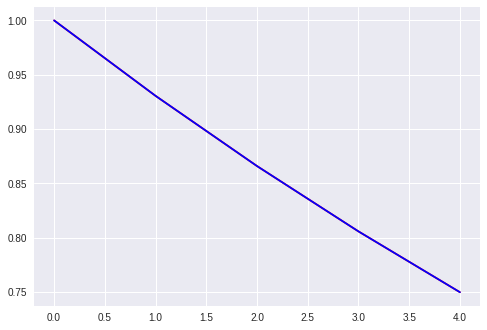

In [0]:
plt.plot(np.array(test_holder_even), c='r')
plt.plot(np.array(test_holder_odd), c='b', )
plt.show()

In [0]:
np.array_equal(np.array(test_holder_even), np.array(test_holder_odd))

True

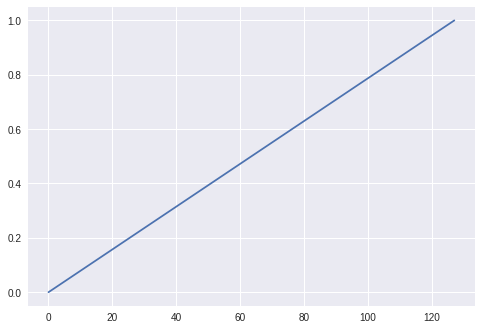

In [0]:
plt.plot(np.linspace(0,1,depth//2))

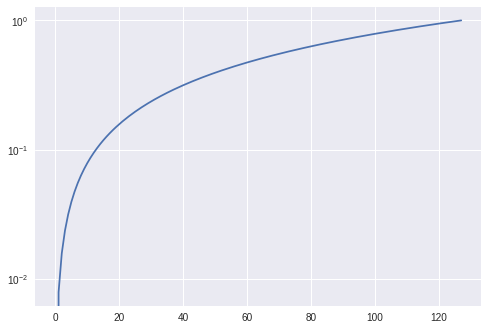

In [0]:
plt.semilogy(np.linspace(0,1,depth//2))

In [0]:
def positional_encoding(position, d_model):
  # pos == num_of words?  ex) (50, 1) - length of sequence
  # i == (1, dim) : ex) 512dim -> (1, 512) - < k == 512: i == 512//2 >
  # d_model == 512 
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]
  return tf.cast(pos_encoding, tf.float32)

In [0]:
pos_encoding = positional_encodeing(50, 512)
print(pos_encoding.shape)

(1, 50, 512)


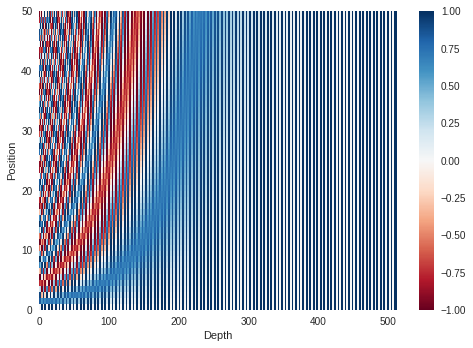

In [0]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [0]:
pos_encoding[0][0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [0]:
pos_encoding[0][1][0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.84147096>

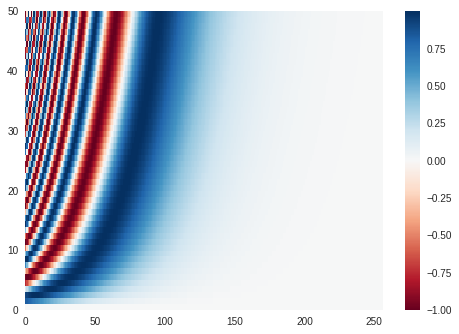

In [0]:
plt.pcolormesh(pos_encoding[0][:, 0::2], cmap='RdBu')
plt.colorbar()

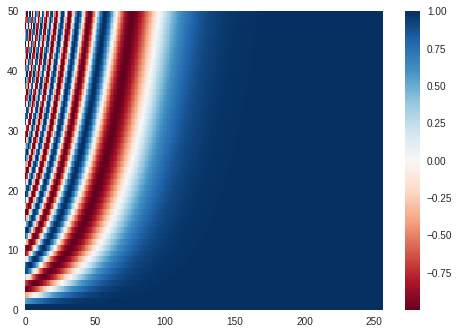

In [0]:
plt.pcolormesh(pos_encoding[0][:, 1::2], cmap='RdBu')
plt.colorbar()

In [0]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  return seq[:, tf.newaxis, tf.newaxis, :]  # return (batchsize, 1, 1, seq_len)

In [0]:
x = tf.constant([[7, 6, 0, 0, 1], 
                 [1, 2, 3, 0, 0], 
                 [0, 0, 0, 4, 5]])

print(x.shape)
create_padding_mask(x)

(3, 5)


<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [0]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [0]:
tf.linalg.band_part(tf.ones((5, 5)), 0, -1)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [0]:
1 - tf.linalg.band_part(tf.ones((5, 5)), 0, -1)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.]], dtype=float32)>

In [0]:
tf.linalg.band_part(tf.ones((5, 5)), -1, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [0]:
1 - tf.linalg.band_part(tf.ones((5, 5)), -1, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [0]:
tf.linalg.band_part(tf.ones((5, 5)), 0, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [0]:
1 - tf.linalg.band_part(tf.ones((5, 5)), 0, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]], dtype=float32)>

In [0]:
x = tf.random.uniform((1, 3))

print(x)
temp = create_look_ahead_mask(x.shape[1])
temp

tf.Tensor([[0.21562552 0.9225062  0.01099646]], shape=(1, 3), dtype=float32)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [0]:
# def scaled_dot_product_attention(q, k, v, mask):
#   # q = (..., seq_len_q, depth)
#   # k = (..., seq_len_k, depth)
#   # v = (..., seq_len_v, depth_v)
#   # mask = (..., seq_len_q, seq_len_k) default == None

#   # Multihead example 
#   # <q, k, v> shapes = (b, 8, -1, 512//8)
#   # Ex) q, k, v == (1, 8, 60, 64)

#   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (b, 8, -1, 512//8) * (512//8, -1, 8, b)

#   d_k = tf.cast(tf.shape(k)[-1], tf.float32)  # 512//8 -> float

#   scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)  # matmul_qk / d_k  # shape == (1, 8, 60, 64)

#   if mask is not None:
#     scaled_attention_logits = scaled_attention_logits + (mask * -1e9)

#   attention_weight = tf.nn.softmax(scaled_attention_logits, axis=-1)  # shape = (1, 8, 60, 60) <- axis == -1

#   # print('att_weight : ', attention_weight.shape)
  
#   output = tf.matmul(attention_weight, v)
#   return output, attention_weight


def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [0]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [0]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)
print(temp_k)
print(temp_k.shape)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
print(temp_v)
print(temp_v.shape)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)


print_out(temp_q, temp_k, temp_v)

tf.Tensor(
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]
 [ 0.  0. 10.]], shape=(4, 3), dtype=float32)
(4, 3)
tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)
(4, 2)
Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [0]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [0]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [0]:
temp_q = tf.constant([[0, 0, 10], 
                      [0, 10, 0], 
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)


print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.d_model = d_model # ex: 512: emb dim
    self.num_heads = num_heads # num of heads to split

    assert d_model % self.num_heads == 0
    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):  
    # Takes input the dense output: 
    # embedding out -> (b, s, emb_dim)
    # wq -> (b, s, h) ex) h == 512
    # reshape to -> (b, -1, 8, 512//8)
    # permutate to -> (b, 8, -1, 512//8)  
    ## 512// 8 == 64
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # print('split_head result : ', x.shape)
    return x

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    q = self.wq(q)  # b, s, h
    k = self.wk(k)  # b, s, h
    v = self.wv(v)  # b, s, h
    # print('wv :', v.shape)

    q = self.split_heads(q, batch_size)  # shape = (b, 8, -1, 512//8)
    k = self.split_heads(k, batch_size)  # shape = (b, 8, -1, 512//8)
    v = self.split_heads(v, batch_size)  # shape = (b, 8, -1, 512//8)
    # print('split head : ', v.shape)


    scaled_attention, attention_weight = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    output = self.dense(concat_attention)

    return output, attention_weight



In [0]:
# Multi Head Attention takes input the embedding output -> (Batch, Seq_length, Emb_dim)
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)

y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model) <- consider those are embedding + positional encoding

# k, v, q = y
out, attn = temp_mha(y, k=y, q=y, mask=None)

out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [0]:
y

<tf.Tensor: shape=(1, 60, 512), dtype=float32, numpy=
array([[[0.46911955, 0.00898051, 0.51062036, ..., 0.8227235 ,
         0.46018612, 0.96623147],
        [0.8840562 , 0.2835245 , 0.1305033 , ..., 0.44752145,
         0.09990597, 0.8429737 ],
        [0.68534863, 0.64006186, 0.683949  , ..., 0.88538456,
         0.4604689 , 0.3772676 ],
        ...,
        [0.29442143, 0.14357209, 0.8656719 , ..., 0.0323385 ,
         0.91944647, 0.3848796 ],
        [0.401062  , 0.33845425, 0.94529974, ..., 0.12993872,
         0.5583235 , 0.30522072],
        [0.90875363, 0.28894985, 0.9019854 , ..., 0.33259833,
         0.09224749, 0.28668773]]], dtype=float32)>

In [0]:
def point_wise_feed_forward(d_model, dff):
  return tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'),
                              tf.keras.layers.Dense(d_model)])
  

In [0]:
sample_ffn = point_wise_feed_forward(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    attn_output, _ = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)

    return out2

In [0]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training = training)
    out2 = self.layernorm2(attn2 + out1)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training = training)
    out3 = self.layernorm3(ffn_output + out2)

    return out3, attn_weights_block1, attn_weights_block2

In [0]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_embedding = positional_encoding(maximum_position_encoding, self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    seq_len = tf.shape(x)[1]

    x = self.embedding(x) # shape: b, seq_len, d_model
    x = x * tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # x / root(x)
    x = x + self.pos_embedding[:, :seq_len, :]
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x

In [0]:
sample_encoder = Encoder(num_layers=2, 
                         d_model=512, 
                         num_heads=8, 
                         dff=2048, 
                         input_vocab_size=8500,
                         maximum_position_encoding=10000)


temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [0]:
sample_encoder.pos_embedding

<tf.Tensor: shape=(1, 10000, 512), dtype=float32, numpy=
array([[[ 0.        ,  1.        ,  0.        , ...,  1.        ,
          0.        ,  1.        ],
        [ 0.84147096,  0.5403023 ,  0.8218562 , ...,  1.        ,
          0.00010366,  1.        ],
        [ 0.9092974 , -0.41614684,  0.9364147 , ...,  1.        ,
          0.00020733,  1.        ],
        ...,
        [ 0.43692413,  0.89949834, -0.82331795, ...,  0.47636065,
          0.8605365 ,  0.5093888 ],
        [ 0.9929729 ,  0.11834206, -0.00257065, ...,  0.47626615,
          0.86058927,  0.5092996 ],
        [ 0.63608694, -0.77161735,  0.820389  , ...,  0.47617164,
          0.8606421 ,  0.5092104 ]]], dtype=float32)>

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training= training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
    
    attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
    attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    return x, attention_weights


In [0]:
sample_decoder = Decoder(num_layers=2, 
                         d_model=512,
                         num_heads=8, 
                         dff=2048, 
                         target_vocab_size=8000,
                         maximum_position_encoding=5000)

temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [0]:
class Transformer(tf.keras.Model):
  # Requires to understand how the mask works during training
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
    self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    enc_output = self.encoder(inp, training, enc_padding_mask)

    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)
    return final_output, attention_weights

In [0]:
sample_transformer = Transformer(num_layers=2,
                                 d_model=512,
                                 num_heads=8,
                                 dff=2048, 
                                 input_vocab_size=8500,
                                 target_vocab_size=8000, 
                                 pe_input=10000,
                                 pe_target=6000)


temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, 
                               temp_target, 
                               training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [0]:
# The Task is pt-in : en-out

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2

target_vocab_size = tokenizer_en.vocab_size + 2

dropout_rate = 0.1

lrate = d^0.5 * min(step_num^-0.5, step_num * warmup_steps^-1.5)

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    print(step)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

tf.Tensor([    0.     1.     2. ... 39997. 39998. 39999.], shape=(40000,), dtype=float32)


Text(0.5, 0, 'Train Step')

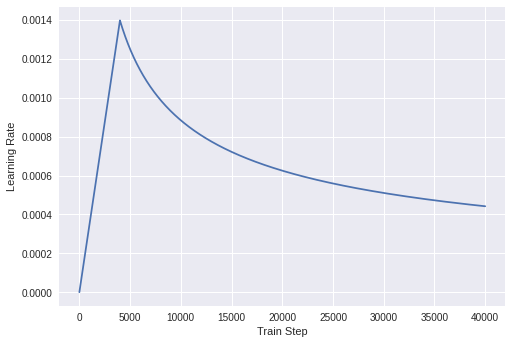

In [0]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [0]:
# loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [0]:
tokenizer_pt.vocab_size

8214

In [0]:
tokenizer_en.vocab_size

8087

In [0]:
# The Task is pt-in : en-out

num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1


transfomer = Transformer(num_layers,
                         d_model,
                         num_heads,
                         dff,
                         input_vocab_size,
                         target_vocab_size,
                         pe_input = input_vocab_size,
                         pe_target = target_vocab_size,
                         rate = dropout_rate)

In [0]:
def create_mask(inp, tar):
  # encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # decoder 2nd attention block 
  dec_padding_mask = create_padding_mask(inp)

  # the look ahead mask use only 1st attention
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)

  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transfomer=transfomer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest Checkpoint Restored!')

In [0]:
# The target sentence : Eng -> SOS A lion in the jungle is sleepling EOS
# Target Input -> SOS A lion in the jungle is sleeping
# Target Ouput -> A lion in the jungle is sleeping EOS

# To avoid re-tracing due to the variabel sequence lengths or variable batch sizes, set input_signature

train_step_signature = [tf.TensorSpec(shape=(None, None), dtype=tf.int64),
                        tf.TensorSpec(shape=(None, None), dtype=tf.int64)]

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [0]:
@tf.function
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, tar)

  with tf.GradientTape() as tape:
    predictions, _ = transfomer(inp, tar_inp,True, enc_padding_mask, combined_mask, dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transfomer.trainable_variables)
  optimizer.apply_gradients(zip(gradient, transfomer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)


In [0]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch+1}, Batch {batch}, Loss: {train_loss.result()}, Acc : {train_accuracy.result}')

  if (epoch+1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving CKPT {epoch+1} -- {ckpt_save_path}')

  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

```
Epoch 20 Batch 0 Loss 0.4771 Accuracy 0.3220
Epoch 20 Batch 50 Loss 0.5079 Accuracy 0.3514
Epoch 20 Batch 100 Loss 0.5093 Accuracy 0.3502
Epoch 20 Batch 150 Loss 0.5184 Accuracy 0.3493
Epoch 20 Batch 200 Loss 0.5239 Accuracy 0.3485
Epoch 20 Batch 250 Loss 0.5285 Accuracy 0.3480
Epoch 20 Batch 300 Loss 0.5319 Accuracy 0.3483
Epoch 20 Batch 350 Loss 0.5356 Accuracy 0.3479
Epoch 20 Batch 400 Loss 0.5389 Accuracy 0.3474
Epoch 20 Batch 450 Loss 0.5409 Accuracy 0.3473
Epoch 20 Batch 500 Loss 0.5429 Accuracy 0.3467
Epoch 20 Batch 550 Loss 0.5446 Accuracy 0.3458
Epoch 20 Batch 600 Loss 0.5478 Accuracy 0.3453
Epoch 20 Batch 650 Loss 0.5517 Accuracy 0.3452
Epoch 20 Batch 700 Loss 0.5543 Accuracy 0.3443
Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Epoch 20 Loss 0.5544 Accuracy 0.3442
Time taken for 1 epoch: 30.97209858894348 secs
```

Evaluate

encode input sentence to pt tokenizer (tokenizer_pt)
add start and end token

decoder input == start token   (tokenizer_en.vocab_size)

get padding masks and look ahead mask

decoder outputs the prection by looing at the encoder outpus 

select last word and cat argmax 

concatenate preidction decoder inputs

In [0]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vcoab_size + 1]

  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token

  encoder_input = tf.expand_dims(inp_sentence, 0)  

  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_mask(encoder_input, output)

    predictions, att_weight = transfomer(encoder_input,
                                         output,
                                         False,
                                         enc_padding_mask,
                                         combined_mask,
                                         dec_padding_mask)
    
    predictions = predictions[:, -1:, :]  # get b, 1, vocab_size

    predicted_id = tf.cast(tf.agrmax(predictions, axis=-1), tf.int32)

    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), att_weight
    
    output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, 0), att_weight

In [0]:
def plot_attention_weight(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))

  sentence = tokenizer_pt.encode(sentence)

  attention = tf.squeeze(attention[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    ax.matshow(attention[head][:-1, :], cmap='viridis')

    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))

    ax.set_ylim(len(reslut)-1.5, -0.5)
    ax.set_xticklabels(['<start>'] + [tokenizer_pt.decode([i]) for i in sentence] + ['<end>'], rotation=90)
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result if i < tokenizer_en.vocab_size])
    
    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  plt.show()

In [0]:
def translate(sentence, plot=''):
  result, att_weight = evaluate(sentence)

  predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size])

  print('input {}'.format(sentence))
  print('predicted {}'.format(predicted_sentence))

  if plot:
    plot_attention_weight(att_weight, sentence, result, plot)

In [0]:
MAX_LENGTH

40